### Load Data & libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import time


In [2]:
# Load data
data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data_transform.csv", header = 0, index_col=0, parse_dates=True, dayfirst=False)

# Select 3 exogenous variables 
# M1: Industrial Production Index
# M7: Retail and Food Services Sale
# M12: Effective Federal Funds Rate 

data_new = data[['GDP', 'M1', 'M7','M12']]
data_new = data_new.dropna()

# Split the data into training and testing sets
train_size = int(len(data_new) * 0.8)

GDP_fill_data  = pd.DataFrame(data_new['GDP'])
GDP_fill_data.index = GDP_fill_data.index + pd.offsets.QuarterEnd(0)
GDP_fill_data_train, GDP_fill_data_test = GDP_fill_data[:train_size], GDP_fill_data[train_size:]
display(GDP_fill_data )

x_data = pd.DataFrame(data_new.iloc[:, 1:])
x_train, x_test = x_data[:train_size], x_data[train_size:]
display(x_data)


,GDP
Date,
1959-06-30,0.022301
1959-09-30,0.000705
1959-12-31,0.002845
1960-03-31,0.022228
1960-06-30,-0.005405
...,...
2018-12-31,0.002229
2019-03-31,0.005960
2019-06-30,0.007898


,M1,M7,M12
Date,,,
1959-06-30,0.012391,0.005828,0.196667
1959-09-30,-0.019971,-0.002374,0.123333
1959-12-31,0.019589,-0.008020,0.076667
1960-03-31,0.002654,0.009733,-0.050000
1960-06-30,-0.007252,0.003164,-0.173333
...,...,...,...
2018-12-31,-0.000848,-0.002520,0.106667
2019-03-29,-0.003236,0.009089,0.046667
2019-06-28,-0.001557,0.003632,-0.010000


### Set up ESN

In [3]:
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN

# construct individual ESN
# K is size of inputs 
K = int(x_data.shape[1])
print(int(x_data.shape[1]))

# build single reservoir ESN with reservoir dim = 30, sparsity = 10/30 (33.3%)

esn_a = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((30, 30), dist='sparse_normal', sparsity=10/30, seed=1234), 

    C=matrixGenerator((30, K), dist='sparse_uniform', sparsity=10/30, seed=1234), 

    zeta=np.zeros((30, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


3


In [4]:
# ESN with reservoir dim = 120, sparsity = 10/120 (8.3%)
esn_b = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((120, 120), dist='sparse_normal', sparsity=10/120, seed=1234), 

    C=matrixGenerator((120, K), dist='sparse_uniform', sparsity=10/120, seed=1234), 

    zeta=np.zeros((120, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)

# ESN with reservoir dim = 250 > 193 (N > T), sparsity = 10/250 (4.0%)
esn_c = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((250 , 250), dist='sparse_normal', sparsity=10/250, seed=1234), 

    C=matrixGenerator((250, K), dist='sparse_uniform', sparsity=10/250, seed=1234), 

    zeta=np.zeros((250, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)

In [5]:
from LibESN.esn_fit import ridgeFit, ridgeCV

# ridge regression with CV to fit single ESN -- test size by default is 1 --> Leave-One-Out CV; one step ahead 

cv_a = ridgeCV().cv(model = esn_a, train_data=(x_train, GDP_fill_data_train), steps = 1, test_size = 5 )

cv_b = ridgeCV().cv(model = esn_b, train_data=(x_train, GDP_fill_data_train), steps = 1, test_size = 5 )

# cv_c = ridgeCV().cv(model = esn_c, train_data=(x_train, GDP_fill_data_train), steps = 1, test_size = 5  )

TypeError: 'train_idxs' is an invalid keyword argument for print()

In [ ]:
print(cv_a['cvLambda'])
print(cv_b['cvLambda'])
print(cv_c['cvLambda'])

#### Model Fitting

In [ ]:
# model fitting
esn_fit_a = esn_a.fit(train_data =(x_train, GDP_fill_data_train), method=ridgeFit(cv_a['cvLambda']), steps=1)

esn_fit_b = esn_b.fit(train_data =(x_train, GDP_fill_data_train), method=ridgeFit(cv_b['cvLambda']), steps=1)

esn_fit_c = esn_c.fit(train_data =(x_train, GDP_fill_data_train), method=ridgeFit(cv_c['cvLambda']), steps=1)

display(esn_fit_a)
display(esn_fit_b)
display(esn_fit_c)

In [ ]:
# one step ahead forecast - fixed parameters
from LibESN.esn_forecast import forecast

forecast_a = forecast(
    model=esn_a,
    forecast_data=x_test,
    fit=esn_fit_a)

forecast_b = forecast(
    model=esn_b,
    forecast_data=x_test,
    fit=esn_fit_b)

forecast_c = forecast(
    model=esn_c,
    forecast_data=x_test,
    fit=esn_fit_c)

len(forecast_a['forecast'])

In [ ]:
# Evaluate the model esn_a
mse_a = mean_squared_error(GDP_fill_data_test, forecast_a['forecast'][0:49])
mae_a = mean_absolute_error(GDP_fill_data_test, forecast_a['forecast'][0:49])
rmse_a = math.sqrt(mse_a)

# Evaluate the model esn_b
mse_b = mean_squared_error(GDP_fill_data_test, forecast_b['forecast'][0:49])
mae_b = mean_absolute_error(GDP_fill_data_test, forecast_b['forecast'][0:49])
rmse_b = math.sqrt(mse_b)

# Evaluate the model esn_c
mse_c = mean_squared_error(GDP_fill_data_test, forecast_c['forecast'][0:49])
mae_c = mean_absolute_error(GDP_fill_data_test, forecast_c['forecast'][0:49])
rmse_c = math.sqrt(mse_c)

# Summary table
rmse_sum = {'Models': ['ESN_A', 'ESN_B', 'ESN_C'], 
            'MAE': [mse_a, mse_b, mse_c ],
            'RMSE': [rmse_a, rmse_b, rmse_c ]}

print(pd.DataFrame(rmse_sum).to_string(index=False))


In [ ]:
# Plot the actual vs. predicted values
plt.plot(data_new.index[:len(GDP_fill_data_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(GDP_fill_data_train):],GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(GDP_fill_data_train):], forecast_a['forecast'][1:], label='Predictions A')
plt.plot(data_new.index[len(GDP_fill_data_train):], forecast_b['forecast'][1:], label='Predictions B')
plt.plot(data_new.index[len(GDP_fill_data_train):], forecast_c['forecast'][1:], label='Predictions C')
plt.legend()
plt.title("1-Step-ahead Forecast for ESN")
plt.show()

#### Setting up with newToolbox_ESN

In [7]:
from newToolbox_ESN import ESN, stateMatrixGenerator, identity
from newToolbox_ESN import ESN
from newToolbox_ESN_Multi import ESNMultiFrequency

K = int(x_data.shape[1])

esn_S_A = ESN(
    N=30,
    A=stateMatrixGenerator(
        (30, 30), 
        dist='sparse_normal', sparsity=10/30, normalize='eig',
        seed=1234
    ),
    C=stateMatrixGenerator(
        (30, int(K)), 
        dist='sparse_uniform', sparsity=10/30, normalize='norm2',
        seed=1234
    ),
    rho=0.5,
    gamma=1,
    leak_rate=0,
    activation=np.tanh,
)

esnSingle_A = ESNMultiFrequency((esn_S_A,), ar=False)

In [8]:
esn_S_B = ESN(
    N=120,
    A=stateMatrixGenerator(
        (120, 120), 
        dist='sparse_normal', sparsity=10/30, normalize='eig',
        seed=1234
    ),
    C=stateMatrixGenerator(
        (120, int(K)), 
        dist='sparse_uniform', sparsity=10/120, normalize='norm2',
        seed=1234
    ),
    rho=0.5,
    gamma=1,
    leak_rate=0,
    activation=np.tanh,
)

esnSingle_B = ESNMultiFrequency((esn_S_B,), ar=False)

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
[]
[]
. CV Options:
['cv', 'test_size']
['10', '5']
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
[144 145 146 147 148]
---------------------------
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  

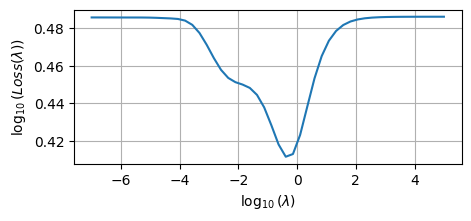

+ s = 0 --------------------
Best solution found:
lambda = [0.49915722]
F      = 2.576992415115747


[array([0.49915722])]

In [11]:
# use CV to find lambda 
esnSingle_A_cv10 = esnSingle_A.ridge_lambda_cv(Y = GDP_fill_data_train, z = (x_train, ), method="ridge",
    cv_options="-cv:10-test_size:5",
    steps=1,
    debug=True )

esnSingle_A_cv10

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '5']
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
[144 145 146 147 148]
---------------------------
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  6

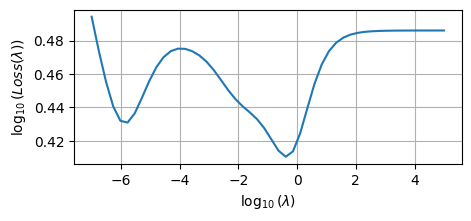

+ s = 0 --------------------
Best solution found:
lambda = [0.43164432]
F      = 2.5730206542585345


[array([0.43164432])]

In [12]:
esnSingle_B_cv10 = esnSingle_B.ridge_lambda_cv(Y = GDP_fill_data_train, z = (x_train, ), method="ridge-isotropic",
    cv_options="-cv:10-test_size:5",
    steps=1,
    debug=True )

esnSingle_B_cv10

In [ ]:
# fit with ridge regression
esnSingle_A_fit = esnSingle_A.fit(Y = GDP_fill_data_train, z= (x_test, ), method ='ridge', Lambda= esnSingle_A_cv10, full = False, debug = False) 

# esnSingle_A_forcast = esnSingle_A.fixedParamsForecast(Yf = GDP_fill_data_test, zf = (x_test, ), fit = esnSingle_A_fit)

##### Expanding window forecast

In [ ]:
forecast_ew = np.zeros((len(GDP_fill_data_test), 1))
for j in tqdm(range(len(GDP_fill_data_test)), desc=" EW", position=1, leave=False):
        if j > 0:
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            x_train_j = pd.concat([
                x_train, 
                x_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.loc[[GDP_test_dates[j-1]],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        md_fill_data_train_j, md_fill_data_test_j = (
            normalize_train_test(md_fill_data_train_j, md_fill_data_test_j)
        )

        #print(np.mean(GDP_fill_data_train_j))
        #print(np.mean(GDP_fill_data_train_j))

        #print(f"j = {j}")
        #print(f"{GDP_fill_data_train_j.index[-1]} | {GDP_fill_data_test_j.index[0]}")
        #print(f"{md_fill_data_train_j.index[-1]} | {md_fill_data_test_j.index[0]} -> {md_fill_data_test_j.index[-1]}")
        #print("-------------------------------")

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ),
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnSingle_fit = esnModel.fit(
            Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ), 
            method='ridge',
            Lambda=Lambda_j,
            full=False,
            debug=False,
        )

        esnSingle_for = esnModel.fixedParamsForecast(
            Yf=GDP_fill_data_test_j, zf=(md_fill_data_test_j, ), 
            fit=esnSingle_fit
        )

        forecast_ew[j] = np.squeeze(esnSingle_for['Forecast'][0]['Y_for']) * sig_j + mu_j
